# Surprise Housing — EDA, Modeling & Test Prediction

In [1]:

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pandas as pd
import os

# Load train dataset
train = pd.read_csv('../Housing-project-train-data.csv')
TARGET = 'SalePrice'
X = train.drop(columns=[TARGET])
y = train[TARGET]

# Split data
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

# Hyperparameter tuning for RandomForest
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

rf_pipe = Pipeline([("prep", preprocess), ("model", RandomForestRegressor(random_state=42))])

grid_search = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(Xtr, ytr)

print("Best parameters for RandomForest:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)


Best parameters for RandomForest: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV R2: 0.8379159675288769


In [2]:

import os, joblib, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import __version__ as sklearn_version
from packaging import version

warnings.filterwarnings('ignore')

TRAIN_CSV = '../Housing-project-train-data.csv'
TEST_CSV  = '../Hosuing-project-test-data.csv'
ARTIFACTS = '../artifacts'
os.makedirs(ARTIFACTS, exist_ok=True)

TARGET = 'SalePrice'

# Load data
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)
display(train.head(), train.shape, test.shape)

# Basic cleaning example: fill missing numerical with median, categorical with most_frequent
num_cols = train.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in train.columns if c not in num_cols]
num_cols.remove(TARGET)

if version.parse(sklearn_version) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", ohe)]), cat_cols),
])

# Train/val split
X = train.drop(columns=[TARGET])
y = train[TARGET]
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=10.0),
    "Lasso": Lasso(alpha=0.001, max_iter=5000),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=200),
    "GradientBoosting": GradientBoostingRegressor(random_state=42, n_estimators=200),
}

results = []
best_name, best_model, best_r2 = None, None, -1e9
for name, est in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", est)])
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xva)
    mse = mean_squared_error(yva, pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(yva, pred)
    results.append({"model": name, "RMSE": rmse, "R2": r2})
    if r2 > best_r2:
        best_name, best_model, best_r2 = name, pipe, r2

print(pd.DataFrame(results).sort_values("R2", ascending=False))

# Fit best on all data
best_model.fit(X, y)
joblib.dump(best_model, os.path.join(ARTIFACTS, f"best_model_{best_name}.joblib"))

# Predict on test
Xtest = test[X.columns]
preds = best_model.predict(Xtest)
pd.DataFrame({ "Id": test["Id"] if "Id" in test.columns else range(len(test)), "SalePrice": preds }).to_csv(os.path.join(ARTIFACTS, "test_predictions.csv"), index=False)

print(f"Best model: {best_name}, R2={best_r2:.4f}")


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,127,120,RL,NaN,4928,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2007,WD,Normal,128000
1,889,20,RL,95.0,15865,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2007,WD,Normal,268000
2,793,60,RL,92.0,9920,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,269790
3,110,20,RL,105.0,11751,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,1,2010,COD,Normal,190000
4,422,20,RL,NaN,16635,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,215000


(1168, 81)

(292, 80)

              model          RMSE        R2
5  GradientBoosting  37035.308235  0.803410
4      RandomForest  38830.591669  0.783888
3        ElasticNet  41343.268175  0.755015
1             Ridge  41750.070346  0.750170
2             Lasso  42959.378521  0.735487
0  LinearRegression  45147.341715  0.707857
Best model: GradientBoosting, R2=0.8034


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    954 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          77 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

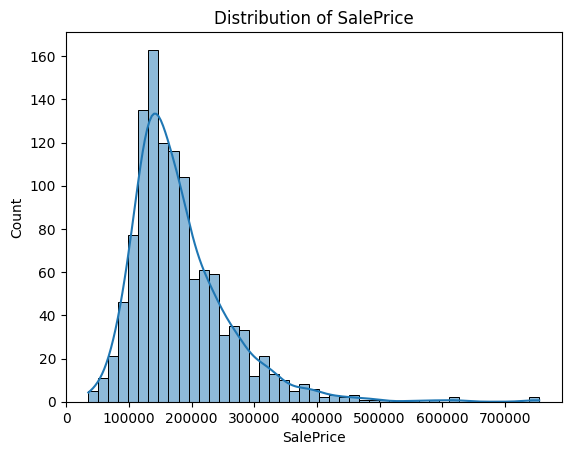

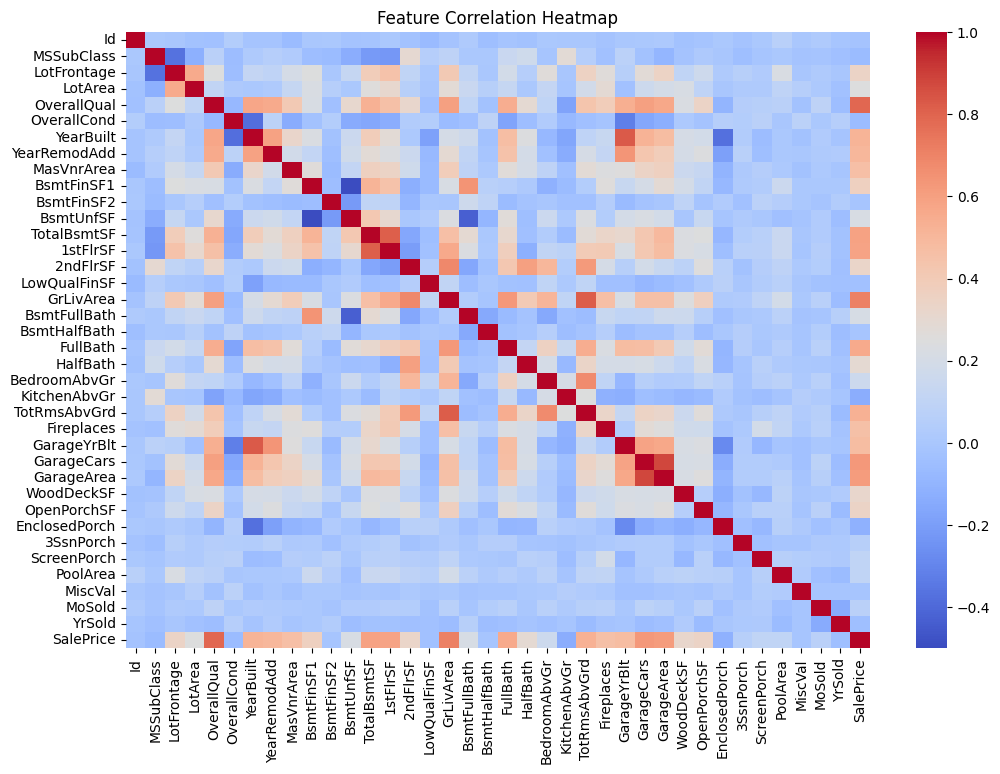

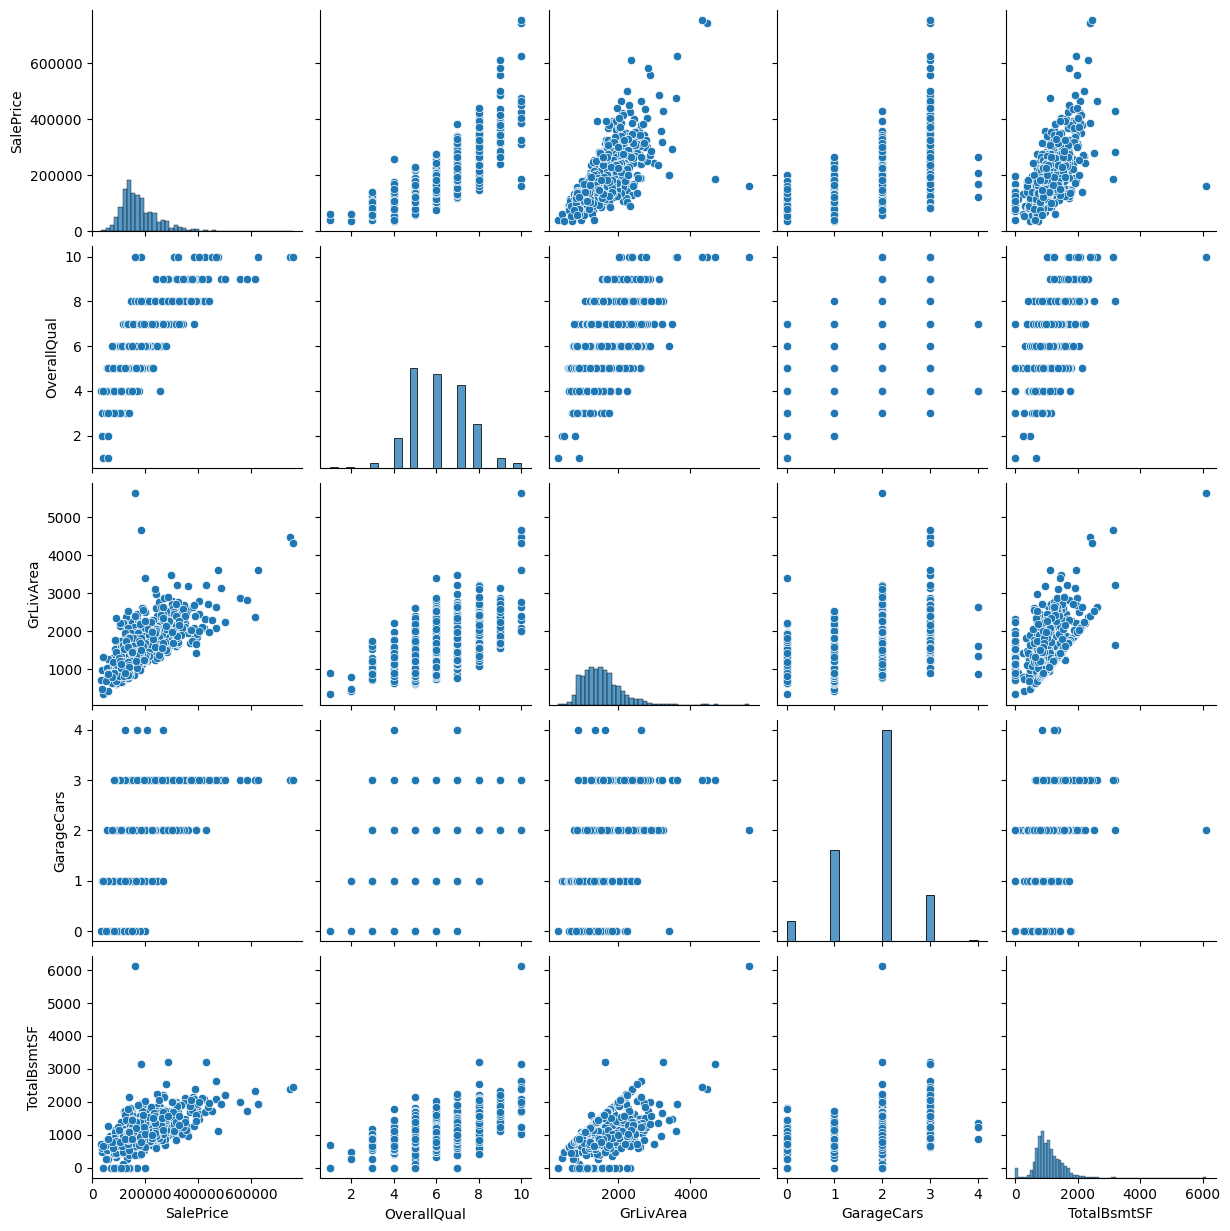

In [3]:

import seaborn as sns
import matplotlib.pyplot as plt

# Basic dataset info
print(train.info())
print(train.describe())

# Missing values count
missing_counts = train.isnull().sum()
print(missing_counts[missing_counts > 0])

# Distribution of target
sns.histplot(train[TARGET], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

# Correlation heatmap (numeric features)
corr = train.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

# Pairplot for a few selected variables
sample_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']
sns.pairplot(train[sample_cols])
plt.show()
